In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomZoom, RandomFlip, RandomRotation
from keras.optimizers import Adam
from keras.applications import VGG16
import keras_tuner as kt
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Dataset'

## Data Preprocessing

In [ ]:
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

train_valid_df = pd.DataFrame(columns=['filepath', 'label'])
test_df = pd.DataFrame(columns=['filepath', 'label'])

for label, folder in enumerate(['muffin', 'chihuahua']):
    folder_path = os.path.join(train_dir, folder)
    image_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]
    train_valid_df = pd.concat([train_valid_df, pd.DataFrame({'filepath': image_files, 'label': str(label)})])

for label, folder in enumerate(['muffin', 'chihuahua']):
    folder_path = os.path.join(test_dir, folder)
    image_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]
    test_df = pd.concat([test_df, pd.DataFrame({'filepath': image_files, 'label': str(label)})])

In [ ]:
train_df, valid_df = train_test_split(train_valid_df, test_size=0.2, random_state = 123)

In [ ]:
data_generator = ImageDataGenerator(rescale=1./255)

train_valid_data = data_generator.flow_from_dataframe(
    dataframe=train_valid_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)



train_data = data_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


valid_data = data_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


test_data = data_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 4733 validated image filenames belonging to 2 classes.
Found 3786 validated image filenames belonging to 2 classes.
Found 947 validated image filenames belonging to 2 classes.
Found 1184 validated image filenames belonging to 2 classes.


# Displaying an Image With Its Corresponding Label

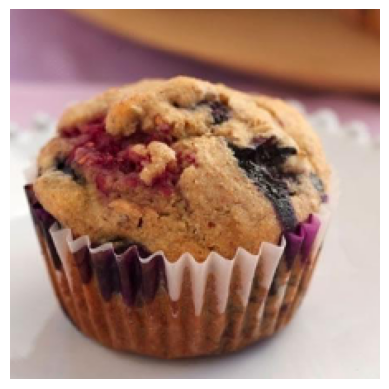

Label: Muffin


In [ ]:
sample_images, sample_labels = next(iter(train_valid_data))
plt.imshow(sample_images[0])
plt.axis('off')
plt.show()
if sample_labels[0] == 0:
    print("Label: Muffin")
else:
    print("Label: Chihuahua")

# Model 1

In [ ]:
# Define the architecture
model1 = Sequential(name='Model1')

# Block 1
model1.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model1.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model1.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model1.add(MaxPooling2D((2, 2), strides=(2, 2)))


# Fully connected layers
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

In [ ]:
model1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
early_stop = [ keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]

Epoch 1/50
147/147 [==============================] - 1147s 8s/step - loss: 0.5376 - accuracy: 0.7575 - val_loss: 0.3991 - val_accuracy: 0.8345
Epoch 2/50
147/147 [==============================] - 91s 622ms/step - loss: 0.3274 - accuracy: 0.8622 - val_loss: 0.3259 - val_accuracy: 0.8826
Epoch 3/50
147/147 [==============================] - 90s 612ms/step - loss: 0.2316 - accuracy: 0.9077 - val_loss: 0.3430 - val_accuracy: 0.8649
Epoch 4/50
147/147 [==============================] - 91s 615ms/step - loss: 0.1373 - accuracy: 0.9511 - val_loss: 0.4989 - val_accuracy: 0.8311
Epoch 5/50
147/147 [==============================] - 89s 608ms/step - loss: 0.0679 - accuracy: 0.9783 - val_loss: 0.5943 - val_accuracy: 0.8378
Epoch 6/50
147/147 [==============================] - 90s 616ms/step - loss: 0.0402 - accuracy: 0.9855 - val_loss: 0.7705 - val_accuracy: 0.8387
Epoch 7/50
37/37 [==============================] - 18s 477ms/step - loss: 0.6360 - accuracy: 0.8623
Test Loss: 0.6359503865242004


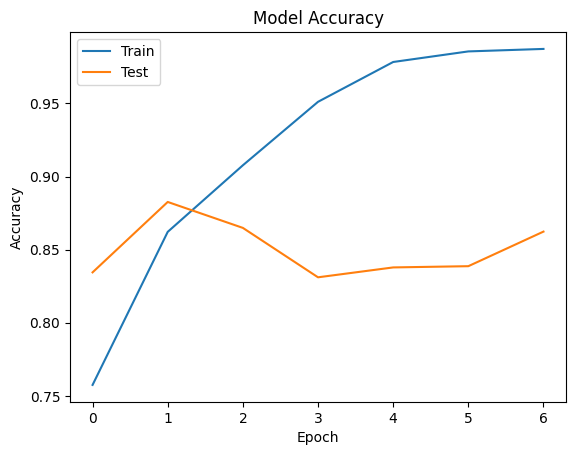

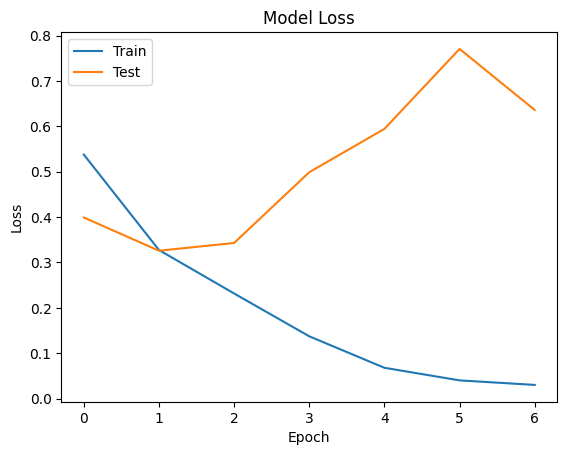

In [ ]:
step_size_train = train_valid_data.n//train_valid_data.batch_size
step_size_validation = test_data.n//test_data.batch_size

history = model1.fit(
    x = train_valid_data,
    steps_per_epoch = step_size_train,
    epochs=50,
    validation_steps = step_size_validation,
    validation_data=test_data,
    callbacks=early_stop
)

test_loss, test_accuracy = model1.evaluate(test_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)



# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Model 2

In [ ]:
# Define the architecture
model2 = Sequential(name='Model2')

# Block 1
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2, 2), strides=(2, 2)))


# Fully connected layers
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
early_stop = [ keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]

Epoch 1/50
147/147 [==============================] - 91s 607ms/step - loss: 0.5225 - accuracy: 0.7471 - val_loss: 0.3981 - val_accuracy: 0.8345
Epoch 2/50
147/147 [==============================] - 92s 629ms/step - loss: 0.3878 - accuracy: 0.8358 - val_loss: 0.3100 - val_accuracy: 0.8775
Epoch 3/50
147/147 [==============================] - 88s 601ms/step - loss: 0.3322 - accuracy: 0.8660 - val_loss: 0.3380 - val_accuracy: 0.8564
Epoch 4/50
147/147 [==============================] - 93s 632ms/step - loss: 0.2705 - accuracy: 0.8970 - val_loss: 0.3156 - val_accuracy: 0.8716
Epoch 5/50
147/147 [==============================] - 87s 596ms/step - loss: 0.2303 - accuracy: 0.9096 - val_loss: 0.2845 - val_accuracy: 0.8936
Epoch 6/50
147/147 [==============================] - 87s 592ms/step - loss: 0.1851 - accuracy: 0.9255 - val_loss: 0.3801 - val_accuracy: 0.8615
Epoch 7/50
147/147 [==============================] - 89s 608ms/step - loss: 0.1421 - accuracy: 0.9455 - val_loss: 0.3479 - val_ac

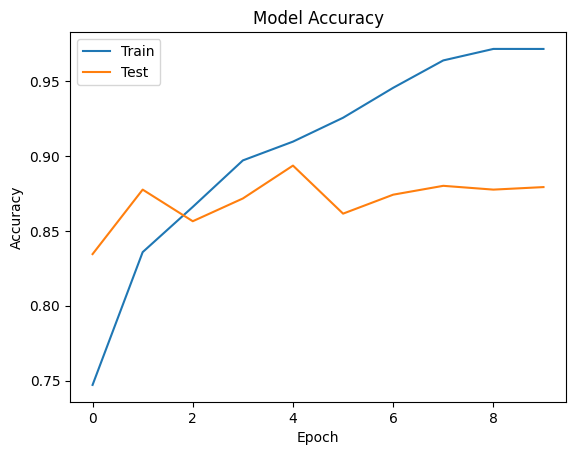

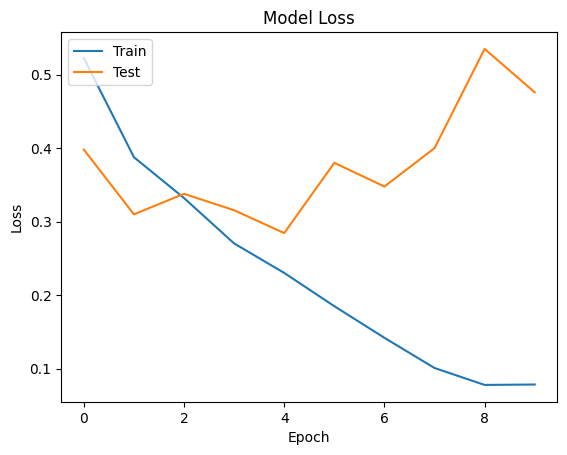

In [ ]:
step_size_train = train_valid_data.n//train_valid_data.batch_size
step_size_validation = test_data.n//test_data.batch_size

history = model2.fit(
    x = train_valid_data,
    steps_per_epoch = step_size_train,
    epochs=50,
    validation_steps = step_size_validation,
    validation_data=test_data,
    callbacks=early_stop
)

test_loss, test_accuracy = model2.evaluate(test_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)



# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Model 3

In [ ]:
# Define the architecture
model3 = Sequential(name='Model3')

# Block 1
model3.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model3.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model3.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model3.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model3.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 4
model3.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model3.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model3.add(MaxPooling2D((2, 2), strides=(2, 2)))


# Fully connected layers
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
early_stop = [ keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]

Epoch 1/50
147/147 [==============================] - 996s 7s/step - loss: 0.5949 - accuracy: 0.6769 - val_loss: 0.5166 - val_accuracy: 0.7500
Epoch 2/50
147/147 [==============================] - 44s 295ms/step - loss: 0.4143 - accuracy: 0.8220 - val_loss: 0.3533 - val_accuracy: 0.8590
Epoch 3/50
147/147 [==============================] - 41s 282ms/step - loss: 0.3449 - accuracy: 0.8583 - val_loss: 0.3483 - val_accuracy: 0.8623
Epoch 4/50
147/147 [==============================] - 41s 278ms/step - loss: 0.3210 - accuracy: 0.8690 - val_loss: 0.2843 - val_accuracy: 0.8919
Epoch 5/50
147/147 [==============================] - 42s 282ms/step - loss: 0.2884 - accuracy: 0.8828 - val_loss: 0.3012 - val_accuracy: 0.8725
Epoch 6/50
147/147 [==============================] - 42s 282ms/step - loss: 0.2777 - accuracy: 0.8868 - val_loss: 0.4263 - val_accuracy: 0.8708
Epoch 7/50
147/147 [==============================] - 44s 296ms/step - loss: 0.2728 - accuracy: 0.8939 - val_loss: 0.2784 - val_accu

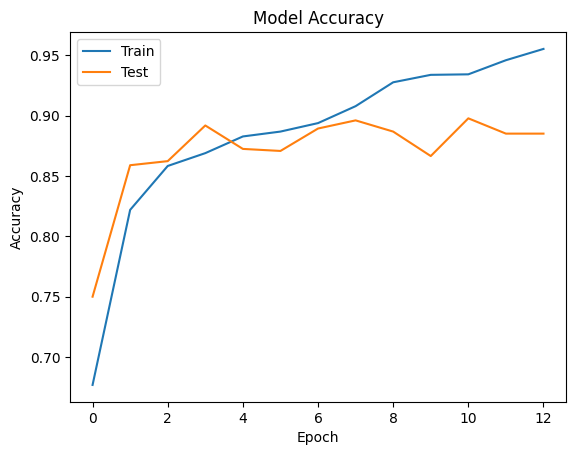

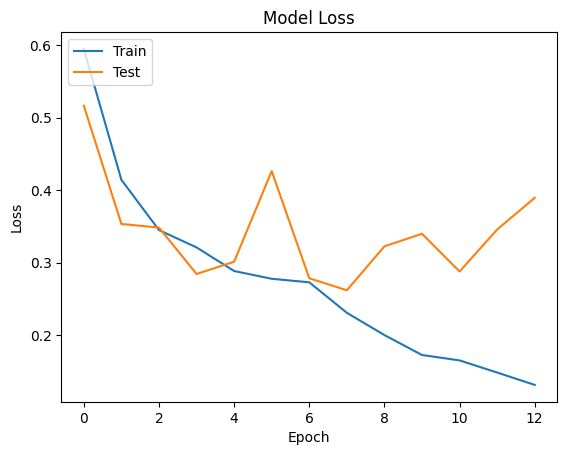

In [ ]:
step_size_train = train_valid_data.n//train_valid_data.batch_size
step_size_validation = test_data.n//test_data.batch_size

history = model3.fit(
    x = train_valid_data,
    steps_per_epoch = step_size_train,
    epochs=50,
    validation_steps = step_size_validation,
    validation_data=test_data,
    callbacks=early_stop
)

test_loss, test_accuracy = model3.evaluate(test_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)



# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Model 4 (Using Data Augmentation Layer and Dropout Layers for the Model 3)

In [ ]:
# Define the data augmentation
data_augmentation = Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.05),
        RandomZoom(0.05)
    ]
)


# Define the architecture
model4 = Sequential(name='Model4')


# Data Augmentation

model4.add(data_augmentation)


# Block 1
model4.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model4.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model4.add(MaxPooling2D((2, 2), strides=(2, 2)))
model4.add(Dropout(0.1))

# Block 2
model4.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model4.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model4.add(MaxPooling2D((2, 2), strides=(2, 2)))
model4.add(Dropout(0.1))
# Block 3
model4.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model4.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model4.add(MaxPooling2D((2, 2), strides=(2, 2)))
model4.add(Dropout(0.1))

# Block 4
model4.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model4.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model4.add(MaxPooling2D((2, 2), strides=(2, 2)))
model4.add(Dropout(0.1))


# Fully connected layers
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.25))
model4.add(Dense(1, activation='sigmoid'))

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
early_stop = [ keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]

Epoch 1/50
147/147 [==============================] - 758s 5s/step - loss: 0.6915 - accuracy: 0.5573 - val_loss: 0.6894 - val_accuracy: 0.5431
Epoch 2/50
147/147 [==============================] - 75s 511ms/step - loss: 0.5064 - accuracy: 0.7624 - val_loss: 0.4802 - val_accuracy: 0.7846
Epoch 3/50
147/147 [==============================] - 76s 514ms/step - loss: 0.3749 - accuracy: 0.8468 - val_loss: 0.3783 - val_accuracy: 0.8404
Epoch 4/50
147/147 [==============================] - 75s 510ms/step - loss: 0.3423 - accuracy: 0.8558 - val_loss: 0.3539 - val_accuracy: 0.8530
Epoch 5/50
147/147 [==============================] - 75s 509ms/step - loss: 0.3380 - accuracy: 0.8628 - val_loss: 0.3142 - val_accuracy: 0.8750
Epoch 6/50
147/147 [==============================] - 74s 505ms/step - loss: 0.3004 - accuracy: 0.8779 - val_loss: 0.3180 - val_accuracy: 0.8691
Epoch 7/50
147/147 [==============================] - 74s 506ms/step - loss: 0.2780 - accuracy: 0.8881 - val_loss: 0.2462 - val_accu

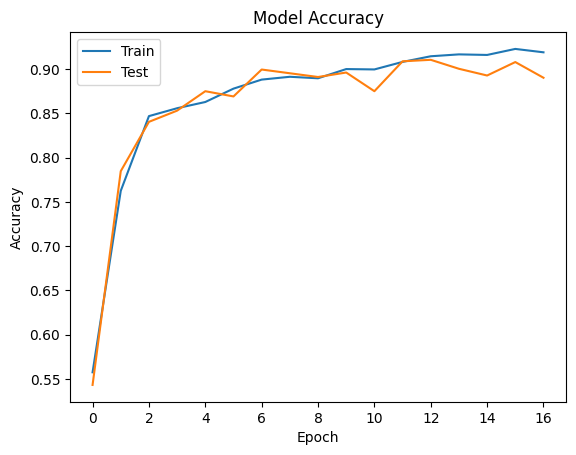

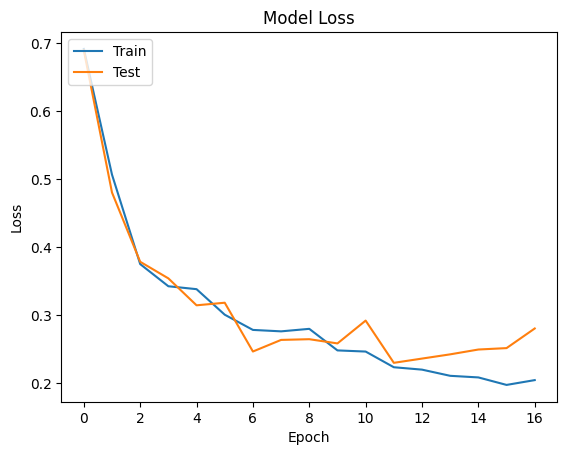

In [ ]:
step_size_train = train_valid_data.n//train_valid_data.batch_size
step_size_validation = test_data.n//test_data.batch_size

history = model4.fit(
    x = train_valid_data,
    steps_per_epoch = step_size_train,
    epochs=50,
    validation_steps = step_size_validation,
    validation_data=test_data,
    callbacks=early_stop
)

test_loss, test_accuracy = model4.evaluate(test_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)



# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Model 6 (Transfer Learning Using VGG16)

In [ ]:
# Define the VGG16 pretrained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# Define the data augmentation
data_augmentation = Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.05),
        RandomZoom(0.05)
    ]
)


# Define the architecture
model5 = Sequential(name='Model5')


# Data Augmentation

model5.add(data_augmentation)


# VGG16 Block

model5.add(base_model)



# Fully connected layers
model5.add(Flatten())
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(1, activation='sigmoid'))

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
early_stop = [ keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]

Epoch 1/50
147/147 [==============================] - 192s 1s/step - loss: 0.1796 - accuracy: 0.9319 - val_loss: 0.0799 - val_accuracy: 0.9713
Epoch 2/50
147/147 [==============================] - 189s 1s/step - loss: 0.0679 - accuracy: 0.9734 - val_loss: 0.0673 - val_accuracy: 0.9764
Epoch 3/50
147/147 [==============================] - 189s 1s/step - loss: 0.0522 - accuracy: 0.9806 - val_loss: 0.0547 - val_accuracy: 0.9814
Epoch 4/50
147/147 [==============================] - 190s 1s/step - loss: 0.0400 - accuracy: 0.9853 - val_loss: 0.0483 - val_accuracy: 0.9823
Epoch 5/50
147/147 [==============================] - 190s 1s/step - loss: 0.0337 - accuracy: 0.9883 - val_loss: 0.0537 - val_accuracy: 0.9797
Epoch 6/50
147/147 [==============================] - 190s 1s/step - loss: 0.0230 - accuracy: 0.9926 - val_loss: 0.0562 - val_accuracy: 0.9831
Epoch 7/50
147/147 [==============================] - 191s 1s/step - loss: 0.0324 - accuracy: 0.9864 - val_loss: 0.0499 - val_accuracy: 0.9814

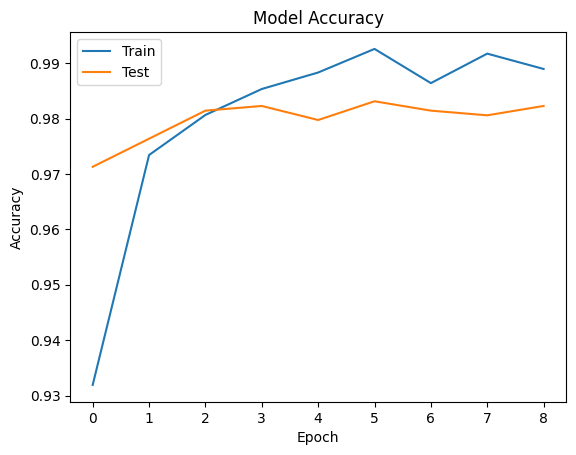

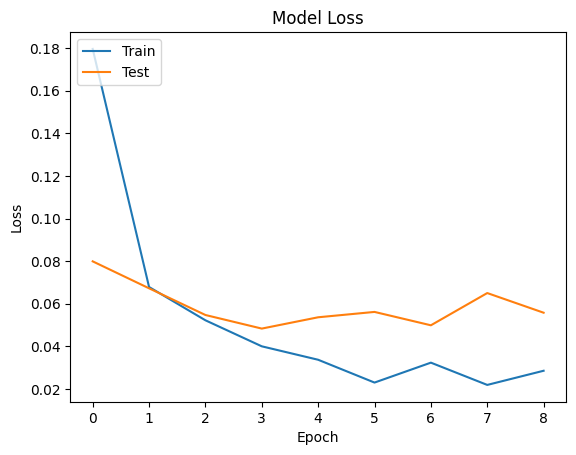

In [ ]:
step_size_train = train_valid_data.n//train_valid_data.batch_size
step_size_validation = test_data.n//test_data.batch_size

history = model5.fit(
    x = train_valid_data,
    steps_per_epoch = step_size_train,
    epochs=50,
    validation_steps = step_size_validation,
    validation_data=test_data,
    callbacks=early_stop
)

test_loss, test_accuracy = model5.evaluate(test_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)




# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Model 5 (Hyperparameter Tuning for the Model 4)

In [ ]:
def build_model(hp):
  #Search Space
  rotation = hp.Float("rotation", min_value = 0.01, max_value = 0.2, step = 0.01)
  zoom = hp.Float("zoom", min_value = 0.01, max_value = 0.2, step = 0.01)
  lr = hp.Choice('lr', values=[1e-2, 1e-3, 1e-4])
  num_filter_b1 = hp.Choice('num_filter_b1', values=[32, 64])
  num_filter_b2 = hp.Choice('num_filter_b2', values=[64, 128])
  num_filter_b3 = hp.Choice('num_filter_b3', values=[128, 256])
  num_filter_b4 = hp.Choice('num_filter_b4', values=[256, 512])
  num_fc = hp.Choice('num_fc', values=[128, 256, 512])
  dropout_block = hp.Float("dropout_block", min_value = 0.05, max_value = 0.15, step = 0.01)
  dropout_fc = hp.Float("dropout_fc", min_value = 0.2, max_value = 0.4, step = 0.05)

  #Define the data augmentation

  data_augmentation = Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(rotation),
        RandomZoom(zoom)
    ]
  )


  # Define the architecture
  model6 = Sequential(name='Model6')


  # Data Augmentation
  model6.add(data_augmentation)


  # Block 1
  model6.add(Conv2D(num_filter_b1, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
  model6.add(Conv2D(num_filter_b1, (3, 3), activation='relu', padding='same'))
  model6.add(MaxPooling2D((2, 2), strides=(2, 2)))
  model6.add(Dropout(dropout_block))

  # Block 2
  model6.add(Conv2D(num_filter_b2, (3, 3), activation='relu', padding='same'))
  model6.add(Conv2D(num_filter_b2, (3, 3), activation='relu', padding='same'))
  model6.add(MaxPooling2D((2, 2), strides=(2, 2)))
  model6.add(Dropout(dropout_block))

  # Block 3
  model6.add(Conv2D(num_filter_b3, (3, 3), activation='relu', padding='same'))
  model6.add(Conv2D(num_filter_b3, (3, 3), activation='relu', padding='same'))
  model6.add(MaxPooling2D((2, 2), strides=(2, 2)))
  model6.add(Dropout(dropout_block))

  # Block 4
  model6.add(Conv2D(num_filter_b4, (3, 3), activation='relu', padding='same'))
  model6.add(Conv2D(num_filter_b4, (3, 3), activation='relu', padding='same'))
  model6.add(MaxPooling2D((2, 2), strides=(2, 2)))
  model6.add(Dropout(dropout_block))


  # Fully connected layers
  model6.add(Flatten())
  model6.add(Dense(num_fc, activation='relu'))
  model6.add(Dropout(dropout_fc))
  model6.add(Dense(1, activation='sigmoid'))

  #Compiling the model

  model6.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

  return model6

In [ ]:
tuner = kt.BayesianOptimization(hypermodel=build_model, objective="val_accuracy", max_trials=10)

In [ ]:
early_stop = [ keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]

In [ ]:
tuner.search(x=train_data, batch_size=32, epochs=50, validation_data=valid_data, callbacks=early_stop)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

Trial 10 Complete [00h 11m 00s]
val_accuracy: 0.5438225865364075

Best val_accuracy So Far: 0.9313622117042542
Total elapsed time: 02h 52m 35s


{'rotation': 0.03,
 'zoom': 0.17,
 'lr': 0.001,
 'num_filter_b1': 32,
 'num_filter_b2': 128,
 'num_filter_b3': 256,
 'num_filter_b4': 256,
 'num_fc': 512,
 'dropout_block': 0.12000000000000001,
 'dropout_fc': 0.35000000000000003}

In [ ]:
#Building the model 4 using the obtained hyperparameters
model4_tuned = tuner.hypermodel.build(best_hps)

Epoch 1/50
147/147 [==============================] - 380s 3s/step - loss: 0.6697 - accuracy: 0.6428 - val_loss: 0.4346 - val_accuracy: 0.8066
Epoch 2/50
147/147 [==============================] - 69s 468ms/step - loss: 0.4039 - accuracy: 0.8258 - val_loss: 0.4517 - val_accuracy: 0.7965
Epoch 3/50
147/147 [==============================] - 70s 478ms/step - loss: 0.3632 - accuracy: 0.8524 - val_loss: 0.3279 - val_accuracy: 0.8725
Epoch 4/50
147/147 [==============================] - 69s 468ms/step - loss: 0.3447 - accuracy: 0.8590 - val_loss: 0.3954 - val_accuracy: 0.8260
Epoch 5/50
147/147 [==============================] - 69s 467ms/step - loss: 0.3362 - accuracy: 0.8609 - val_loss: 0.3286 - val_accuracy: 0.8775
Epoch 6/50
147/147 [==============================] - 69s 471ms/step - loss: 0.3111 - accuracy: 0.8779 - val_loss: 0.2968 - val_accuracy: 0.8801
Epoch 7/50
147/147 [==============================] - 69s 470ms/step - loss: 0.2860 - accuracy: 0.8881 - val_loss: 0.3195 - val_accu

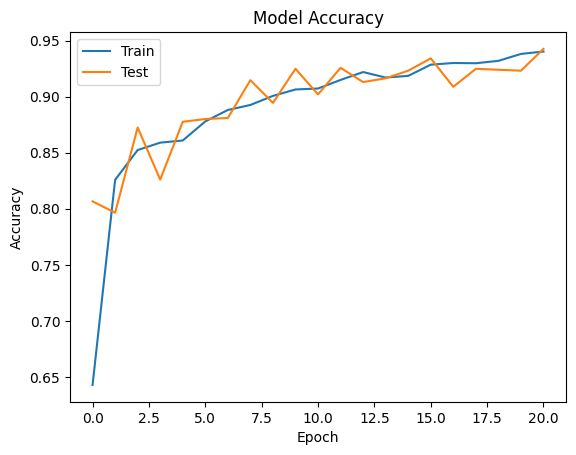

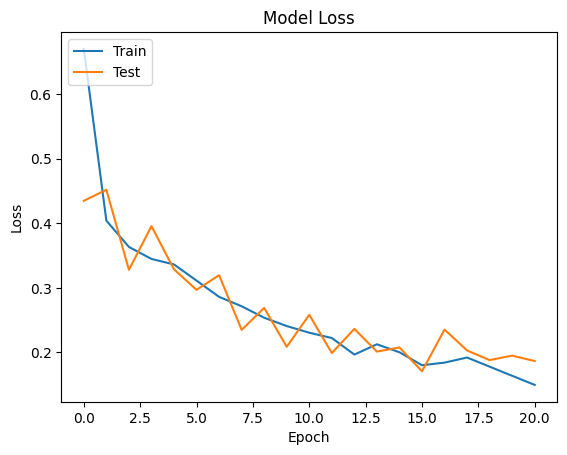

In [ ]:
step_size_train = train_valid_data.n//train_valid_data.batch_size
step_size_validation = test_data.n//test_data.batch_size

history = model4_tuned.fit(
    x = train_valid_data,
    steps_per_epoch = step_size_train,
    epochs=50,
    validation_steps = step_size_validation,
    validation_data=test_data,
    callbacks=early_stop
)

test_loss, test_accuracy = model4_tuned.evaluate(test_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)



# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 5-Fold Cross Validation for the Model 6

In [ ]:
#Redefining model 5 using a function

def build_model5():

  # Define the VGG16 pretrained model
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  for layer in base_model.layers:
      layer.trainable = False

  # Define the data augmentation
  data_augmentation = Sequential(
      [
          RandomFlip("horizontal"),
          RandomRotation(0.05),
          RandomZoom(0.05)
      ]
  )


  # Define the architecture
  model7 = Sequential(name='Model7')


  # Data Augmentation

  model7.add(data_augmentation)


  # VGG16 Block

  model7.add(base_model)



  # Fully connected layers
  model7.add(Flatten())
  model7.add(Dense(128, activation='relu'))
  model7.add(Dropout(0.25))
  model7.add(Dense(1, activation='sigmoid'))

  #Compiling the model
  model7.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

  return model7

In [ ]:
tensorboard = [keras.callbacks.TensorBoard(log_dir="./results",)]

In [ ]:
# Initialize the StratifiedKFold object
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare the data for cross-validation
filepaths = train_valid_df.filepath.values
labels = train_valid_df.label.values

# Placeholder arrays for validation metrics
val_losses = []
val_accuracies = []

# Placeholder for history objects
histories = []

# Perform cross-validation
for train_index, valid_index in kfold.split(filepaths, labels):
    # Split the data into training and validation sets
    train_files, valid_files = filepaths[train_index], filepaths[valid_index]
    train_labels, valid_labels = labels[train_index], labels[valid_index]

    # Create data generators for the current fold
    train_data = data_generator.flow_from_dataframe(
        dataframe=pd.DataFrame({'filepath': train_files, 'label': train_labels}),
        x_col='filepath',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    valid_data = data_generator.flow_from_dataframe(
        dataframe=pd.DataFrame({'filepath': valid_files, 'label': valid_labels}),
        x_col='filepath',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        shuffle=False
    )


    model = build_model5()

    # Train the model on the current fold
    history = model.fit(
        x = train_data,
        steps_per_epoch = train_data.n//train_data.batch_size,
        epochs = 10,
        validation_steps = valid_data.n//valid_data.batch_size,
        validation_data = valid_data,
        callbacks = tensorboard
    )

    histories.append(history)

    # Evaluate the model on the validation set
    valid_loss, valid_accuracy = model.evaluate(valid_data)
    val_losses.append(valid_loss)
    val_accuracies.append(valid_accuracy)

# Calculate the average validation loss and accuracy
avg_val_loss = np.mean(val_losses)
avg_val_accuracy = np.mean(val_accuracies)

print(f'Average Validation Loss: {avg_val_loss}')
print(f'Average Validation Accuracy: {avg_val_accuracy}')

Found 3786 validated image filenames belonging to 2 classes.
Found 947 validated image filenames belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
118/118 [==============================] - 539s 5s/step - loss: 0.3499 - accuracy: 0.8785 - val_loss: 0.0756 - val_accuracy: 0.9763
Epoch 2/10
118/118 [==============================] - 162s 1s/step - loss: 0.0945 - accuracy: 0.9646 - val_loss: 0.0719 - val_accuracy: 0.9688
Epoch 3/10
118/118 [==============================] - 171s 1s/step - loss: 0.0757 - accuracy: 0.9715 - val_loss: 0.0560 - val_accuracy: 0.9806
Epoch 4/10
118/118 [==============================] - 162s 1s/step - loss: 0.0549 - accuracy: 0.9806 - val_loss: 0.1048 - val_accuracy: 0.9655
Epoch 5/10
118/118 [==============================] - 162s 1s/step - loss: 0.0534 - accuracy: 0.9811 - val_loss: 0.0557 - val_accuracy: 0.9763
Epoch 6/10
118/118 [==============================] - 163s 1s/step - loss: 0.0396 - accuracy: 0.987

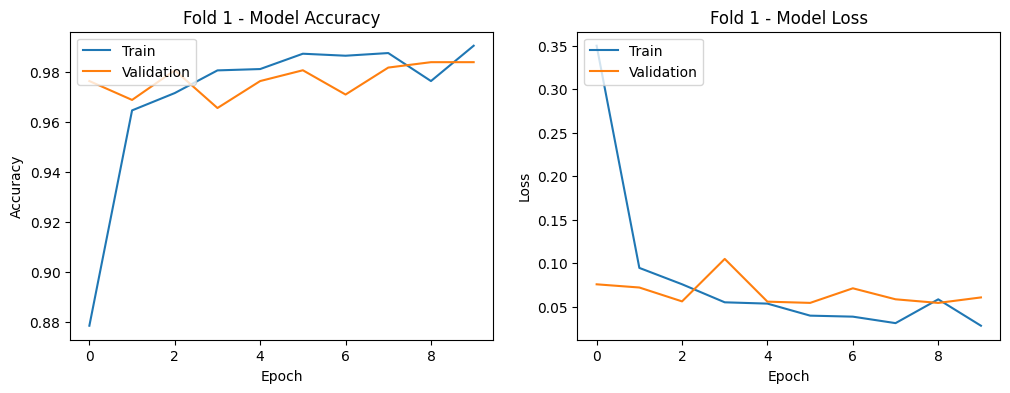

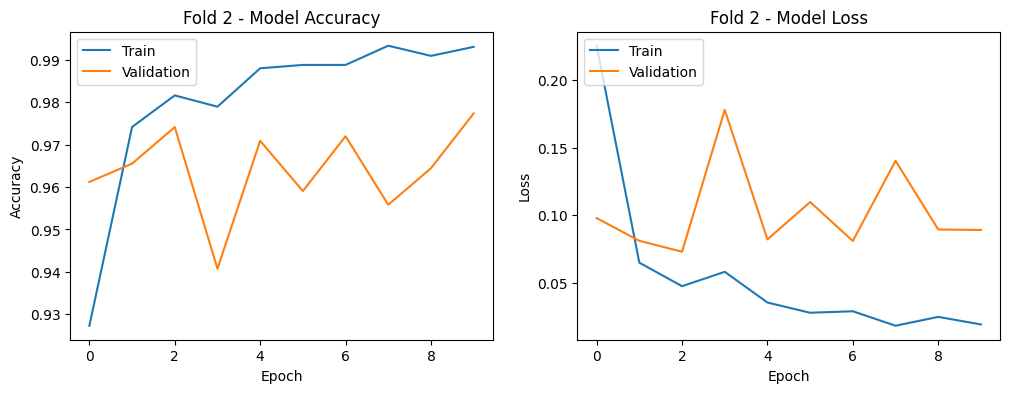

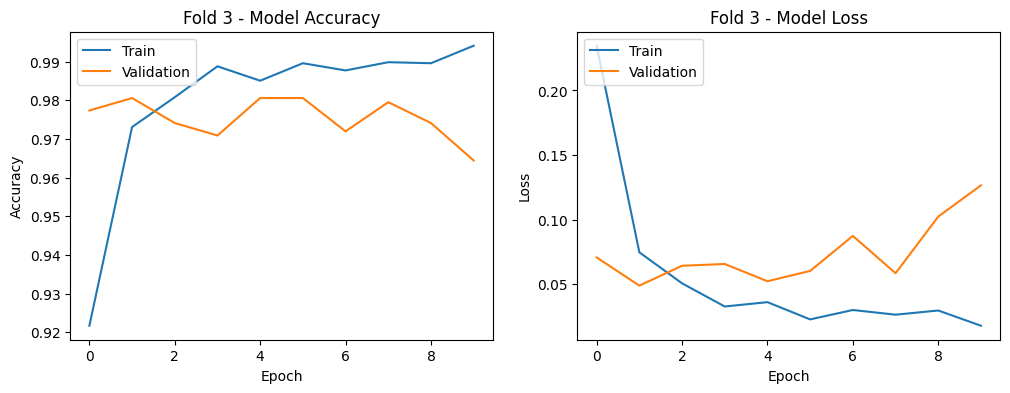

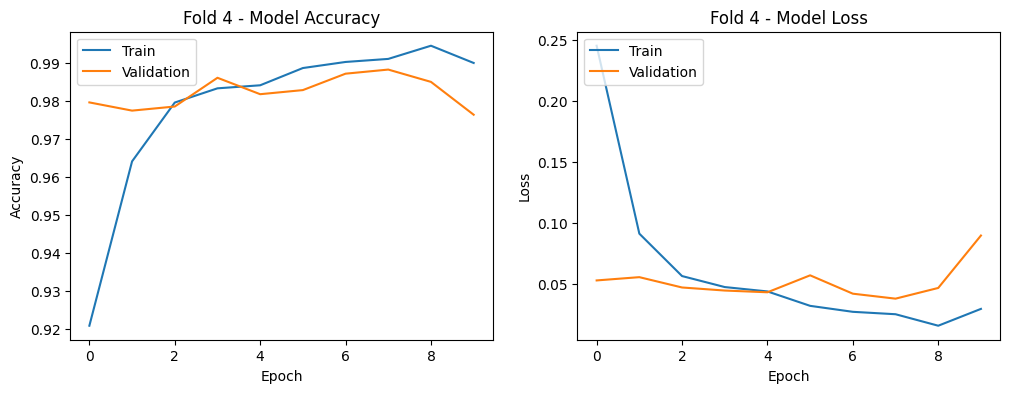

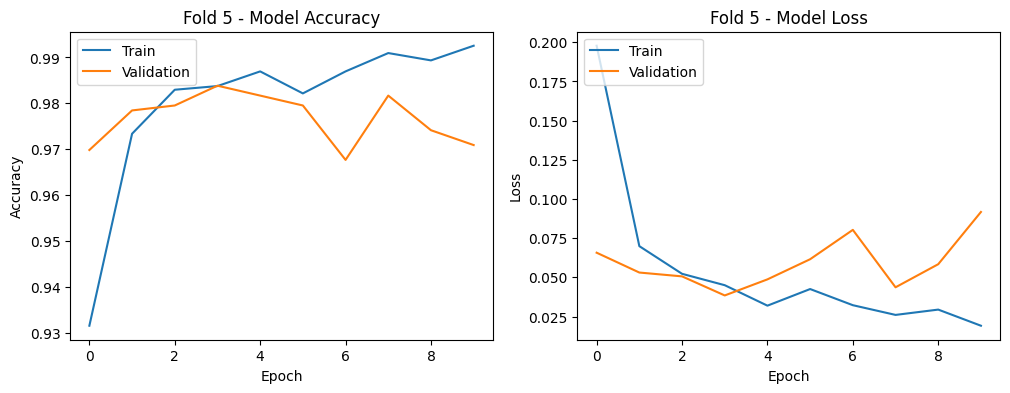

In [ ]:
# Plot the training and validation loss and accuracy for each fold

for i, history in enumerate(histories):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Fold {i + 1} - Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Fold {i + 1} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()